<h1  style="color:white; background-color: #154360; padding:30px;"> 
Résultats numériques pour l'algorithme Neural Optimal Stopping en dimension 1 </h1>

In [32]:
import sys
import helper_plots


sys.path.append("..")


import numpy as np

import src.tools.diffusion.black_scholes as bs
import src.tools.option.option_main_class as option
import torch
from torch import nn
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import src.main.nos.nos_class_one_dimensional as nos_1D

Dans ce notebook, je présente mon implémentation de l'algorithme Neural Optimal Stopping en dimension 1 (voir [Neural Optimal Stopping](https://arxiv.org/pdf/2205.04595)).

### Learning rate tuning

In [33]:
n_path = 500000
batch_size = 50000
n_simulation = 50
epochs = 200


spot = 36
strike = 40
vol = 0.4
rate = 0.06
maturity = 1

activation_function = nn.ReLU()
list_weights = [40,30]
asset = [bs.BlackScholes(spot, rate, vol) for _ in range(1)]
payoff = lambda x: torch.maximum((strike - torch.squeeze(x)), torch.tensor(0))
epsilon = (strike * vol) / np.sqrt(n_simulation)
l_girsanov = rate / vol

option_ = option.Option(maturity,strike,rate,payoff)
nos = nos_1D.NosOneDimensional(asset,option_)

In [34]:
learning_rate = 1e-2
sharp_region, history, _, time_taken = nos.find_optimal_region(
    n_simulation,
    n_path,
    epsilon,
    l_girsanov,
    batch_size,
    learning_rate,
    epochs,
    activation_function,
    list_weights,
    epochs,
    verbose=False,
)

100%|██████████| 200/200 [00:49<00:00,  4.04it/s]


In [35]:
minutes, sec = int(time_taken / 60), int(time_taken % 60)
print(f"time taken is {minutes} minutes and {sec} seconds")

time taken is 0 minutes and 52 seconds


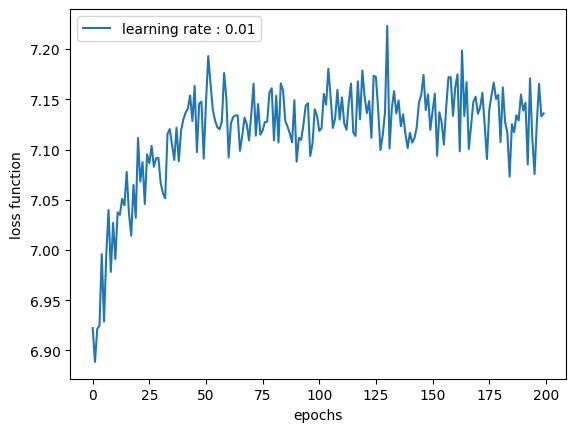

In [36]:
plt.plot(history,label=f'learning rate : {learning_rate}')
plt.ylabel("loss function")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [37]:
nos.get_price(sharp_region,epsilon,50,10000)

(tensor(6.9602, dtype=torch.float64),
 tensor(8.8344, dtype=torch.float64),
 tensor(5.0861, dtype=torch.float64))

In [38]:
p

tensor(4.4087, dtype=torch.float64)

On constate que ça ne change pas grand chose, l'instabilité doit venir de l'erreur monte-carlo.


**TODO** : augmenter batch_size

### Forme de la région stop 

In [39]:
N_path = 1000
dt = float(1/(n_simulation-1))
bs_object = bs.BlackScholes(spot,rate,vol)
paths = bs_object.get_path(n_simulation+1,dt,N_path)

In [40]:
epsilon

2.262741699796952

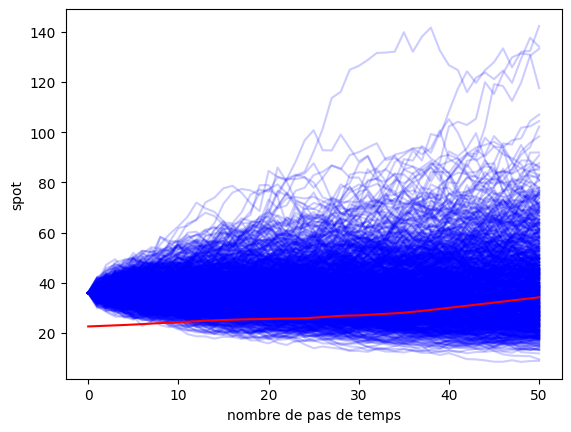

In [41]:
for i in range(N_path):
    plt.plot(paths[i,:],color='blue',alpha=0.2)

timesteps = torch.tensor([dt*i for i in range(n_simulation+1)],dtype=torch.double)
stop_region = torch.squeeze(sharp_region(timesteps.unsqueeze(1)))
stop_region = stop_region.detach().numpy()



plt.xlabel("nombre de pas de temps")
plt.ylabel("spot")
plt.plot(stop_region,color='red')

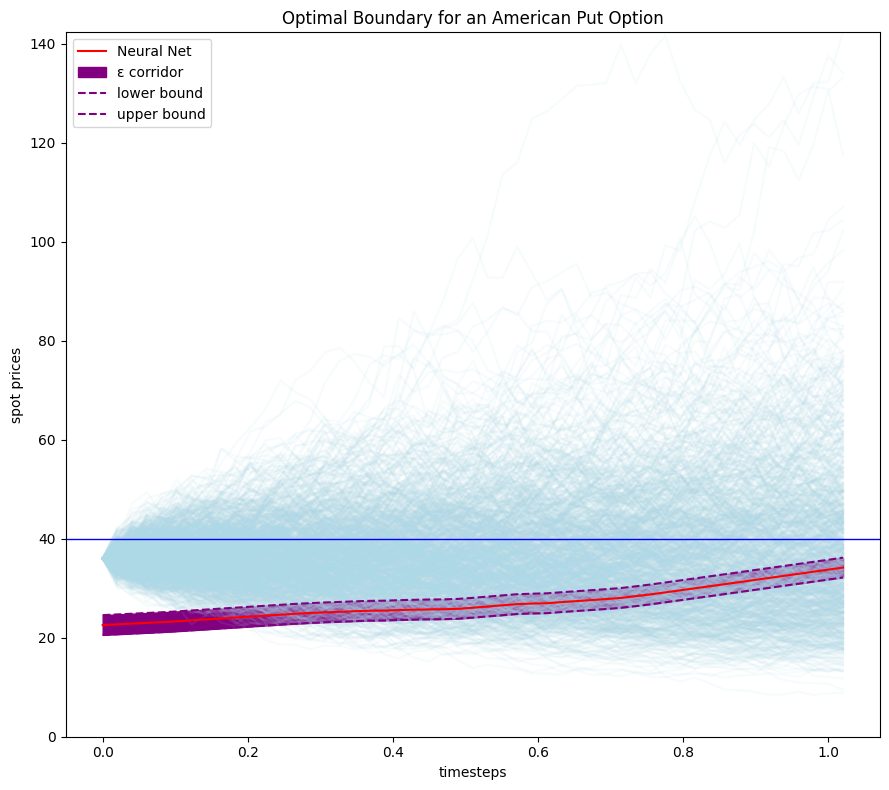

In [42]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(9, 8))

timesteps = torch.tensor([dt * i for i in range(n_simulation + 1)], dtype=torch.double)
stop_region = torch.squeeze(sharp_region(timesteps.unsqueeze(1)))
stop_region = stop_region.detach().numpy()

# Corridor ε
epsilon_corridor = 2  # Taille du corridor
lower_bound = stop_region - epsilon_corridor
upper_bound = stop_region + epsilon_corridor

for i in range(N_path):
    plt.plot(timesteps.numpy(), paths[i, :], color="lightblue", alpha=0.1)
plt.plot(timesteps.numpy(), stop_region, color="red", label="Neural Net")
plt.fill_between(
    timesteps.numpy(),
    lower_bound,
    upper_bound,
    color="purple",
    label="ε corridor",
    alpha=1,
)
plt.plot(
    timesteps.numpy(), lower_bound, color="purple", label="lower bound", linestyle="--"
)
plt.plot(
    timesteps.numpy(), upper_bound, color="purple", label="upper bound", linestyle="--"
)
plt.axhline(y=40, color="blue", linewidth=1)  # Ligne à 40
plt.ylim(0, np.max(paths))
plt.ylabel("spot prices")
plt.xlabel("timesteps")
plt.title("Optimal Boundary for an American Put Option")
plt.legend()

# Afficher le tout
plt.tight_layout()
plt.show()

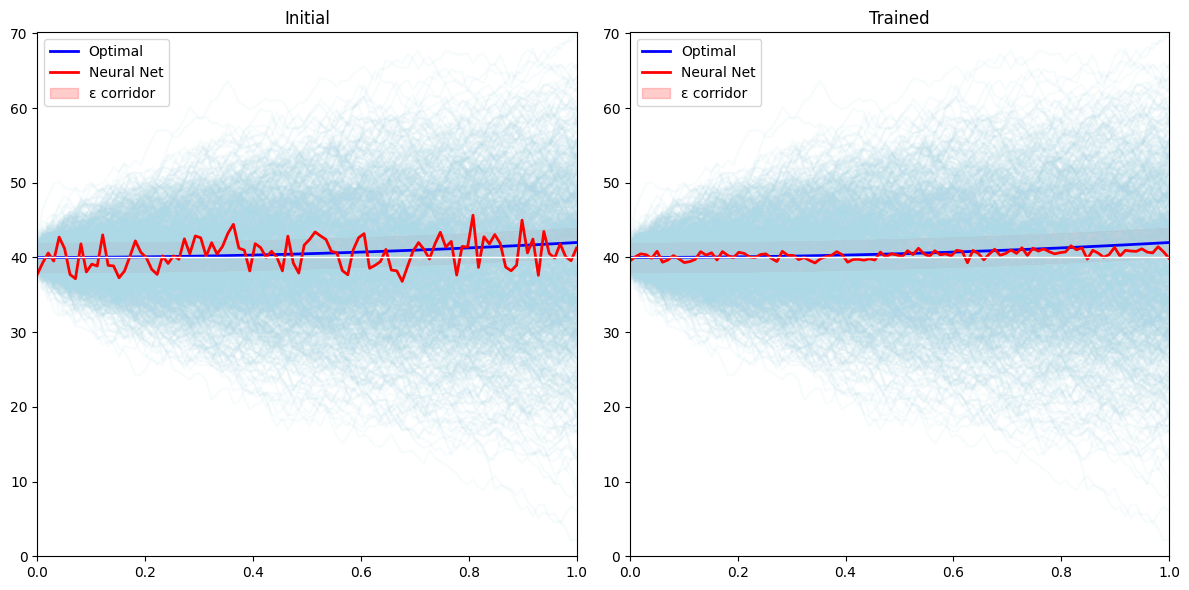

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de simulation
T = 1  # Temps final
N = 1000  # Nombre de trajectoires
timesteps = 100  # Nombre d'intervalles de temps
time = np.linspace(0, T, timesteps)

# Simulation de trajectoires aléatoires (par exemple pour un mouvement brownien)
def generate_trajectories(N, timesteps):
    return 40 + np.cumsum(np.random.randn(N, timesteps), axis=1)

# Trajectoires simulées
trajectories = generate_trajectories(N, timesteps)

# Solution optimale (par exemple une courbe déterministe)
optimal_solution = 40 + 2 * time**2

# Modèle de réseau de neurones (au hasard au début et plus proche de l'optimal après entraînement)
initial_nn_solution = 40 + time + np.random.randn(timesteps) * 2
trained_nn_solution = 40 + time**2 + np.random.randn(timesteps) * 0.5

# Corridor ε
epsilon_corridor = 2  # Taille du corridor
lower_bound = optimal_solution - epsilon_corridor
upper_bound = optimal_solution + epsilon_corridor

# Fonction pour créer les graphes
def plot_trajectories(trajectories, optimal_solution, nn_solution, title):
    plt.plot(time, trajectories.T, color='lightblue', alpha=0.1)
    plt.plot(time, optimal_solution, color='blue', label='Optimal', linewidth=2)
    plt.plot(time, nn_solution, color='red', label='Neural Net', linewidth=2)
    plt.fill_between(time, lower_bound, upper_bound, color='red', alpha=0.2, label='ε corridor')
    plt.axhline(y=40, color='white', linewidth=1)  # Ligne à 40
    plt.xlim(0, T)
    plt.ylim(0, np.max(trajectories))
    plt.title(title)
    plt.legend()

# Création des deux sous-graphiques
plt.figure(figsize=(12, 6))

# Graphe initial
plt.subplot(1, 2, 1)
plot_trajectories(trajectories, optimal_solution, initial_nn_solution, "Initial")

# Graphe après entraînement
plt.subplot(1, 2, 2)
plot_trajectories(trajectories, optimal_solution, trained_nn_solution, "Trained")

# Afficher le tout
plt.tight_layout()
plt.show()

### Analyse variance Monte-Carlo

In [44]:
learning_rate = 1e-2
epochs = 200
mlp = nos_1D.NeuralNetworkNos(strike / 2, nn.ReLU(), 1)
nos = nos_1D.NosOneDimensional(asset, 1, rate, payoff, mlp)
sharp_region, history, history_var, time_taken = nos.find_optimal_region(
    n_simulation,
    n_path,
    epsilon,
    l_girsanov,
    batch_size,
    learning_rate,
    epochs,
    epochs,
    verbose=False,
)

AttributeError: module 'src.main.nos.nos_class_one_dimensional' has no attribute 'NeuralNetworkNos'

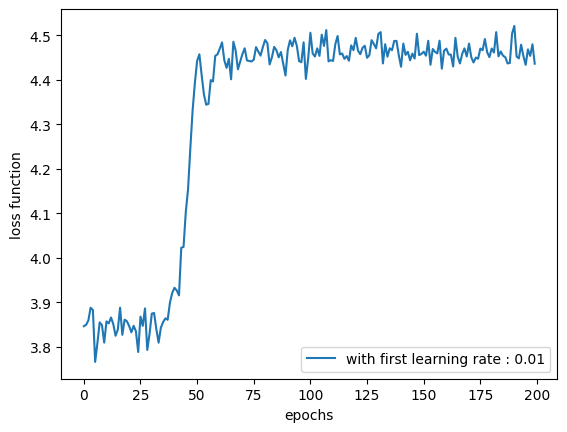

In [ ]:
plt.plot(history,label=f'with first learning rate : {learning_rate}')
plt.ylabel("loss function")
plt.xlabel("epochs")
plt.legend()
plt.show()

Text(0.5, 1.0, 'monte_carlo variance')

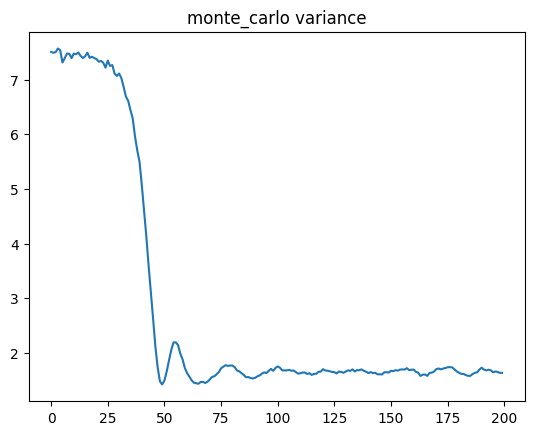

In [ ]:
plt.plot(history_var)
plt.title("monte_carlo variance")

In [ ]:
learning_rate = 1e-2
n_path = 3000000
batch_size = 200000
epochs = 200
mlp = nos_1D.NeuralNetworkNos(strike / 2, nn.ReLU(), 1)
nos = nos_1D.NosOneDimensional(asset, 1, rate, payoff, mlp)
sharp_region, history, history_var, time_taken = nos.find_optimal_region(
    n_simulation,
    n_path,
    epsilon,
    l_girsanov,
    batch_size,
    learning_rate,
    epochs,
    epochs,
    verbose=False,
)

100%|██████████| 200/200 [11:10<00:00,  3.35s/it]


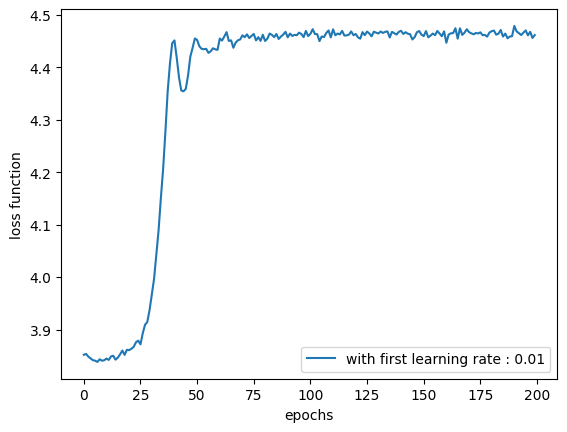

In [ ]:
plt.plot(history,label=f'with first learning rate : {learning_rate}')
plt.ylabel("loss function")
plt.xlabel("epochs")
plt.legend()
plt.show()

Text(0.5, 1.0, 'monte_carlo variance')

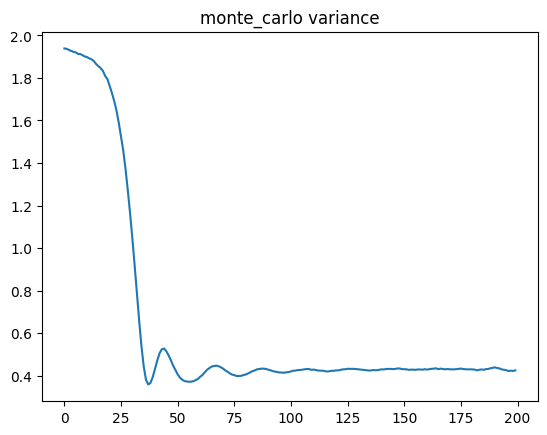

In [ ]:
plt.plot(history_var)
plt.title("monte_carlo variance")

### LeakyRelU

testing different values for the slope paramater

In [ ]:
list_slope = np.arange(start=1,stop=10,step=2)

In [ ]:
learning_rate = 1e-2
n_path = 300000
batch_size = 10000
epochs = 100
list_history = []

for slope in list_slope:
    mlp = nos_1D.NeuralNetworkNos(strike / 2, nn.LeakyReLU(negative_slope=slope), 1)
    nos = nos_1D.NosOneDimensional(asset, 1, rate, payoff, mlp)
    _, history, _, _ = nos.find_optimal_region(
        n_simulation,
        n_path,
        epsilon,
        l_girsanov,
        batch_size,
        learning_rate,
        epochs,
        epochs,
        verbose=False,
    )
    list_history.append(history)

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


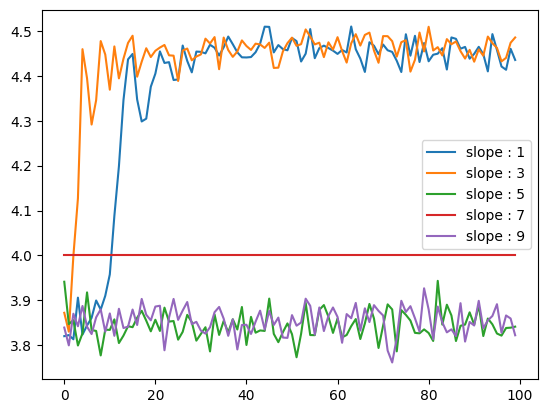

In [ ]:
for slope, hist in zip(list_slope,list_history):
    plt.plot(hist,label=f'slope : {slope}')
plt.legend()

In [ ]:
list_slope = np.arange(start=0.01,stop=2,step=0.3)

In [ ]:
learning_rate = 1e-2
n_path = 300000
batch_size = 10000
epochs = 50
list_history = []

for slope in list_slope:
    mlp = nos_1D.NeuralNetworkNos(strike / 2, nn.LeakyReLU(negative_slope=slope), 1)
    nos = nos_1D.NosOneDimensional(asset, 1, rate, payoff, mlp)
    _, history, _, _ = nos.find_optimal_region(
        n_simulation,
        n_path,
        epsilon,
        l_girsanov,
        batch_size,
        learning_rate,
        epochs,
        epochs,
        verbose=False,
    )
    list_history.append(history)

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


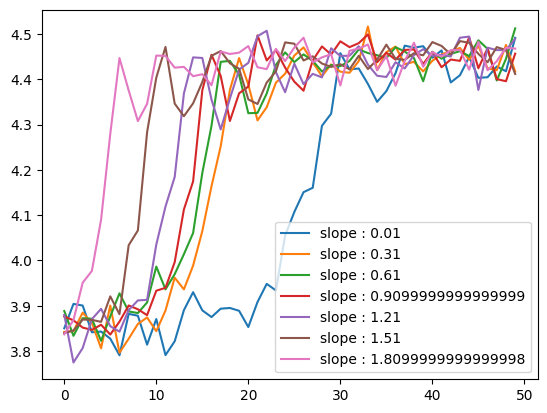

In [ ]:
for slope, hist in zip(list_slope,list_history):
    plt.plot(hist,label=f'slope : {slope}')
plt.legend()

In [ ]:
learning_rate = 1e-4
n_path = 300000
batch_size = 10000
epochs = 100
list_history = []

mlp = nos_1D.NeuralNetworkNos(strike / 2, nn.LeakyReLU(negative_slope=2.5), 1)
nos = nos_1D.NosOneDimensional(asset, 1, rate, payoff, mlp)
_, history, _, _ = nos.find_optimal_region(
    n_simulation,
    n_path,
    epsilon,
    l_girsanov,
    batch_size,
    learning_rate,
    epochs,
    epochs,
    verbose=False,
)

100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


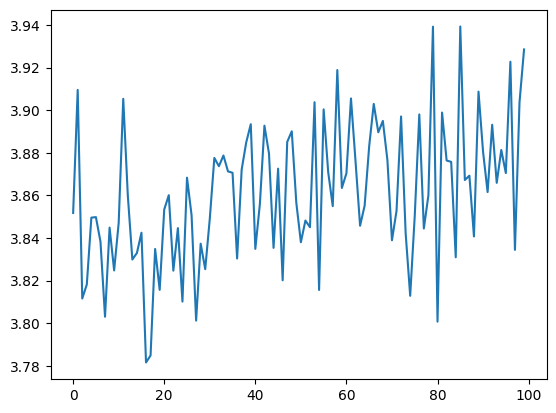

In [ ]:
plt.plot(history)